In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt

In [2]:
# Load OD matrix
df = pd.read_excel('../data/czech/data_czech.xlsx')

# Rename column for clarity and reshape to long format
df = df.rename(columns={'University ↓ / Student →': 'origin'}).melt(id_vars='origin', var_name='destination', value_name='value')

# Clean up leading/trailing spaces
df['origin'] = df['origin'].str.strip()
df['destination'] = df['destination'].str.strip()

# Display tail
df.head()

,origin,destination,value
0,Hlavní město Praha,Hlavní město Praha,29879
1,Jihomoravský kraj,Hlavní město Praha,986
2,Jihočeský kraj,Hlavní město Praha,572
3,Královéhradecký kraj,Hlavní město Praha,366
4,Liberecký kraj,Hlavní město Praha,324


In [3]:
# Load spatial regions
gdf = gpd.read_file('../data/czech/regions.gpkg')

# Keep only necessary columns and compute centroids
gdf = gdf[['nazev', 'geometry']]

# Compute centroids
gdf['centroid'] = gdf.geometry.centroid

# Show the result
gdf.head()

,nazev,geometry,centroid
0,Hlavní město Praha,"MULTIPOLYGON (((4644153.668 3017220.732, 46441...",POINT (4640553.289 3004667.586)
1,Jihočeský kraj,"MULTIPOLYGON (((4614559.886 2946839.972, 46145...",POINT (4644571.676 2896376.941)
2,Plzeňský kraj,"MULTIPOLYGON (((4557165.672 3003874.933, 45571...",POINT (4554357.223 2947867.821)
3,Karlovarský kraj,"MULTIPOLYGON (((4521107.248 3042368.860, 45211...",POINT (4517635.093 3010561.894)
4,Liberecký kraj,"MULTIPOLYGON (((4672911.633 3113397.259, 46729...",POINT (4673801.100 3077989.990)


In [4]:
# Merge centroids for origin and destination
df = df.merge(gdf[['nazev', 'centroid']], left_on='origin', right_on='nazev', how='left').rename(columns={'centroid': 'centroid_origin'}).drop(columns='nazev')
df = df.merge(gdf[['nazev', 'centroid']], left_on='destination', right_on='nazev', how='left').rename(columns={'centroid': 'centroid_destination'}).drop(columns='nazev')

# Filter valid rows (positive flow values and non-null centroids)
df = df[(df['value'] > 0) & df['centroid_origin'].notnull() & df['centroid_destination'].notnull()]

# Create flow lines based on centroids
df['geometry'] = df.apply(lambda row: LineString([row['centroid_origin'], row['centroid_destination']]), axis=1)

# Convert to GeoDataFrame
gdf_flows = gpd.GeoDataFrame(df, geometry='geometry', crs=gdf.crs)

# Weight the flow lines based on value
gdf_flows['weight'] = gdf_flows['value'] / gdf_flows['value'].max() * 10

# Show the result
gdf_flows

,origin,destination,value,centroid_origin,centroid_destination,geometry,weight
0,Hlavní město Praha,Hlavní město Praha,29879,POINT (4640553.289 3004667.586),POINT (4640553.289 3004667.586),"LINESTRING (4640553.289 3004667.586, 4640553.2...",10.000000
1,Jihomoravský kraj,Hlavní město Praha,986,POINT (4805095.894 2907028.912),POINT (4640553.289 3004667.586),"LINESTRING (4805095.894 2907028.912, 4640553.2...",0.329998
2,Jihočeský kraj,Hlavní město Praha,572,POINT (4644571.676 2896376.941),POINT (4640553.289 3004667.586),"LINESTRING (4644571.676 2896376.941, 4640553.2...",0.191439
3,Královéhradecký kraj,Hlavní město Praha,366,POINT (4737782.659 3046863.964),POINT (4640553.289 3004667.586),"LINESTRING (4737782.659 3046863.964, 4640553.2...",0.122494
4,Liberecký kraj,Hlavní město Praha,324,POINT (4673801.100 3077989.990),POINT (4640553.289 3004667.586),"LINESTRING (4673801.100 3077989.990, 4640553.2...",0.108437
...,...,...,...,...,...,...,...
177,Plzeňský kraj,Moravskoslezský kraj,85,POINT (4554357.223 2947867.821),POINT (4894160.179 2998762.522),"LINESTRING (4554357.223 2947867.821, 4894160.1...",0.028448
178,Středočeský kraj,Moravskoslezský kraj,39,POINT (4647193.792 2997678.741),POINT (4894160.179 2998762.522),"LINESTRING (4647193.792 2997678.741, 4894160.1...",0.013053
179,Kraj Vysočina,Moravskoslezský kraj,15,POINT (4732189.380 2938122.688),POINT (4894160.179 2998762.522),"LINESTRING (4732189.380 2938122.688, 4894160.1...",0.005020
180,Zlínský kraj,Moravskoslezský kraj,655,POINT (4884267.534 2930505.177),POINT (4894160.179 2998762.522),"LINESTRING (4884267.534 2930505.177, 4894160.1...",0.219218


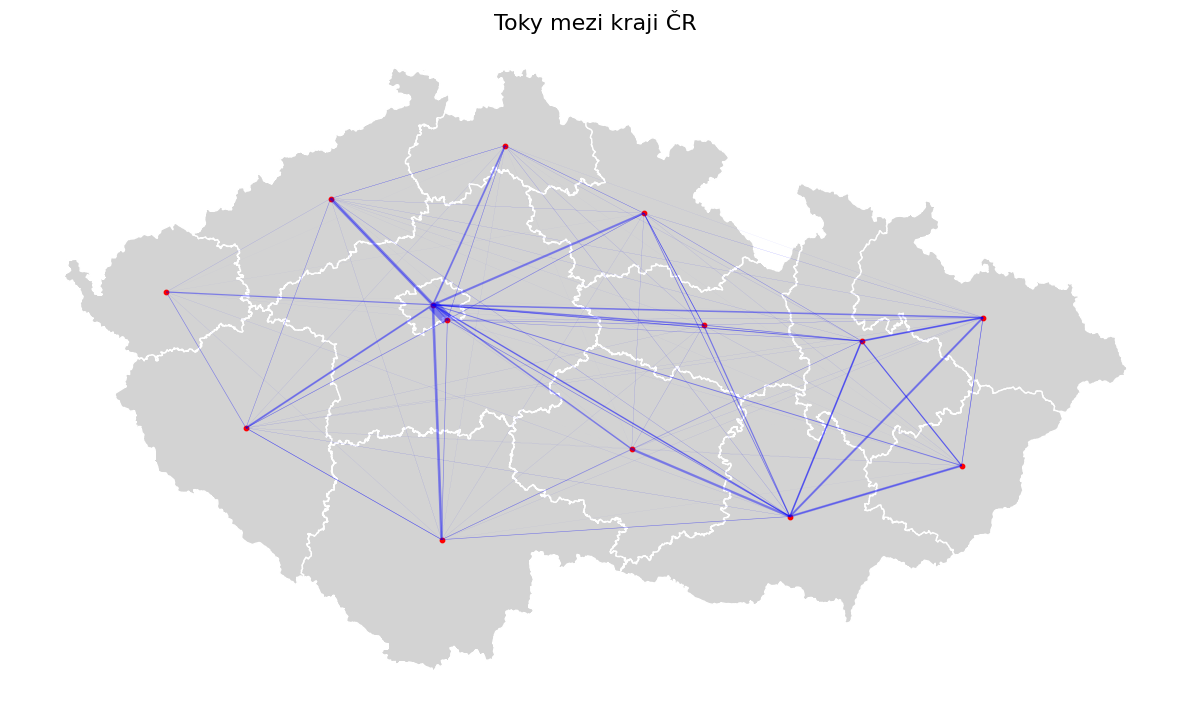

In [5]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot regions, flows, and centroids
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf_flows.plot(ax=ax, linewidth=gdf_flows['weight'], color='blue', alpha=0.4)
gdf.set_geometry('centroid').plot(ax=ax, color='red', markersize=10)

# Set plot title and remove axis
ax.set_title("Toky mezi kraji ČR", fontsize=16)
ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.patches import Circle

# Zkontroluj souřadnicové systémy
print("CRS geometrie krajů:", gdf.crs)
print("CRS centroidů:", gdf_toky.crs)

# Pokud nejsou stejné, převeď (např. na EPSG:5514 nebo 3857 nebo 4326)
# gdf = gdf.to_crs("EPSG:XXXX")
# gdf_toky = gdf_toky.to_crs(gdf.crs)

# GeoDataFrame s centroidy
gdf_body = gdf_toky.set_geometry('centroid')

# Vykreslení mapy
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Pozadí: krajské hranice
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# 3. Vykreslení kruhů
for idx, row in gdf_body.iterrows():
    centroid = row['centroid']
    if centroid is None or centroid.is_empty:
        continue
    
    x, y = centroid.x, centroid.y
    prichozi = row['prichozi']
    odchozi = row['odchozi']
    celkem = prichozi + odchozi

    if celkem == 0:
        continue

    # Škálovací faktor — můžeš si hrát s touto hodnotou
    scale = 50

    # Poloměry (podle odmocniny)
    r_total = np.sqrt(celkem) * scale
    r_prichozi = np.sqrt(prichozi) * scale

    # Vnější červený kruh (celkový)
    ring = Circle((x, y), r_total, color='crimson', alpha=0.3, zorder=2)
    # Vnitřní zelený kruh (příchozí)
    center = Circle((x, y), r_prichozi, color='limegreen', alpha=0.6, zorder=3)

    ax.add_patch(ring)
    ax.add_patch(center)

# Zajištění, že se zobrazení přizpůsobí geometrickým objektům
ax.set_xlim(gdf.total_bounds[[0, 2]])
ax.set_ylim(gdf.total_bounds[[1, 3]])

# Legenda
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Příchozí studenti', markerfacecolor='limegreen', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Odchozí studenti (okraj)', markerfacecolor='crimson', markersize=10, alpha=0.4),
]

ax.legend(handles=legend_elements, loc='lower left')

# Titulek a formát
ax.set_title("Poměr příchozích (zeleně) a odchozích (červeně) studentů podle kraje", fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()


CRS geometrie krajů: EPSG:3035


NameError: name 'gdf_toky' is not defined